In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/new-plant-diseases-dataset


In [ ]:
train_dir ="/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
valid_dir = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"

In [ ]:
import pathlib
import numpy as np

data_dir = pathlib.Path(train_dir)

class_names = np.array(sorted([item.name for item in data_dir.glob("*") if item.is_dir()]))
print(class_names)


['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy' 'Blueberry___healthy'
 'Cherry_(including_sour)___Powdery_mildew'
 'Cherry_(including_sour)___healthy'
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
 'Corn_(maize)___Common_rust_' 'Corn_(maize)___Northern_Leaf_Blight'
 'Corn_(maize)___healthy' 'Grape___Black_rot'
 'Grape___Esca_(Black_Measles)'
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)' 'Grape___healthy'
 'Orange___Haunglongbing_(Citrus_greening)' 'Peach___Bacterial_spot'
 'Peach___healthy' 'Pepper,_bell___Bacterial_spot'
 'Pepper,_bell___healthy' 'Potato___Early_blight' 'Potato___Late_blight'
 'Potato___healthy' 'Raspberry___healthy' 'Soybean___healthy'
 'Squash___Powdery_mildew' 'Strawberry___Leaf_scorch'
 'Strawberry___healthy' 'Tomato___Bacterial_spot' 'Tomato___Early_blight'
 'Tomato___Late_blight' 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tomato___Tom

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

source_train_dir = train_dir
target_train20_dir = "train80"

def create_train50_split():
    if os.path.exists(target_train20_dir):
        shutil.rmtree(target_train20_dir)
    os.makedirs(target_train20_dir, exist_ok=True)

    for class_name in os.listdir(source_train_dir):
        class_path = os.path.join(source_train_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        images = [img for img in images if img.lower().endswith((".jpg", ".jpeg", ".png"))]

        # Split to 50%
        train_half, _ = train_test_split(images, test_size=0.2, random_state=42)

        # Create class folder in train50
        class_target_path = os.path.join(target_train20_dir, class_name)
        os.makedirs(class_target_path, exist_ok=True)

        for img in train_half:
            shutil.copy(os.path.join(class_path, img), os.path.join(class_target_path, img))

    print("✅ 20% training data created in 'train50/' from 'data_augm/train/'.")

create_train50_split()

✅ 20% training data created in 'train50/' from 'data_augm/train/'.


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

source_train_dir = valid_dir
target_train20_dir = "valid20_1"

def create_train50_split():
    if os.path.exists(target_train20_dir):
        shutil.rmtree(target_train20_dir)
    os.makedirs(target_train20_dir, exist_ok=True)

    for class_name in os.listdir(source_train_dir):
        class_path = os.path.join(source_train_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        images = [img for img in images if img.lower().endswith((".jpg", ".jpeg", ".png"))]

        # Split to 50%
        train_half, _ = train_test_split(images, test_size=0.75, random_state=42)

        # Create class folder in train50
        class_target_path = os.path.join(target_train20_dir, class_name)
        os.makedirs(class_target_path, exist_ok=True)

        for img in train_half:
            shutil.copy(os.path.join(class_path, img), os.path.join(class_target_path, img))

    print("✅ 20% training data created in 'train50/' from 'data_augm/train/'.")

create_train50_split()

✅ 20% training data created in 'train50/' from 'data_augm/train/'.


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, image_size=(128, 128), batch_size=16)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir, image_size=(128, 128), batch_size=16)



Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


In [ ]:


# Load datasets
img_size = (128, 128)
batch_size = 16

num_classes = len(class_names)



# Build base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze initially

# Custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model_resnet_50 = Model(inputs=base_model.input, outputs=outputs)


# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
model_ckpt = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_loss')


# Stage 2: Fine-tune top 50 layers
base_model.trainable = True
for layer in base_model.layers[:-50]:  # Freeze all but the last 25 layers
    layer.trainable = False

# Recompile with lower LR
model_resnet_50.compile(optimizer=Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune
history_50_percent_resnet_fine = model_resnet_50.fit(train_ds,
                     epochs=6,
                     validation_data=val_ds,
                     callbacks=[early_stop, reduce_lr, model_ckpt])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/6
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 337s 71ms/step - accuracy: 0.3803 - loss: 2.4577 - val_accuracy: 0.9410 - val_loss: 0.1884 - learning_rate: 1.0000e-05
Epoch 2/6
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 222s 51ms/step - accuracy: 0.8871 - loss: 0.3758 - val_accuracy: 0.9709 - val_loss: 0.0892 - learning_rate: 1.0000e-05
Epoch 3/6
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 223s 51ms/step - accuracy: 0.9448 - loss: 0.1791 - val_accuracy: 0.9822 - val_loss: 0.0585 - learning_rate: 1.0000e-05
Epoch 4/6
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 261s 51ms/step - accuracy: 0.9713 - loss: 0.0966 - val_accuracy: 0.9855 - val_loss: 0.0477 - learning_rate: 1.0000e-05
Epoch 5/6
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 262s 51ms/step - accuracy: 0.9808 - loss: 0.0634 - val_accuracy: 0.9865 - val_loss: 0.0454 - learning_rate: 1.0000e-05
Epoch 6/6
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 222s 50ms/step - accuracy: 0.9873 - loss: 0.0405 - val_accuracy: 0.9873 - val_loss: 0.0446 - learning_rate: 

In [ ]:
model_resnet_50.save('ResNet50_Unfreeze.h5')

In [ ]:
model_resnet_50.evaluate(val_ds)

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.9802 - loss: 0.0630


[0.059923190623521805, 0.9808786511421204]

In [ ]:
from google.colab import files
files.upload()

Saving helper_functions.py to helper_functions (1).py


{'helper_functions (1).py': b'### We create a bunch of helpful functions throughout the course.\n### Storing them here so they\'re easily accessible.\n\nimport tensorflow as tf\n\n# Create a function to import an image and resize it to be able to be used with our model\ndef load_and_prep_image(filename, img_shape=224, scale=True):\n  """\n  Reads in an image from filename, turns it into a tensor and reshapes into\n  (224, 224, 3).\n\n  Parameters\n  ----------\n  filename (str): string filename of target image\n  img_shape (int): size to resize target image to, default 224\n  scale (bool): whether to scale pixel values to range(0, 1), default True\n  """\n  # Read in the image\n  img = tf.io.read_file(filename)\n  # Decode it into a tensor\n  img = tf.image.decode_jpeg(img)\n  # Resize the image\n  img = tf.image.resize(img, [img_shape, img_shape])\n  if scale:\n    # Rescale the image (get all values between 0 and 1)\n    return img/255.\n  else:\n    return img\n\n# Note: The followi

In [ ]:
import helper_functions
from helper_functions import compare_historys, plot_loss_curves

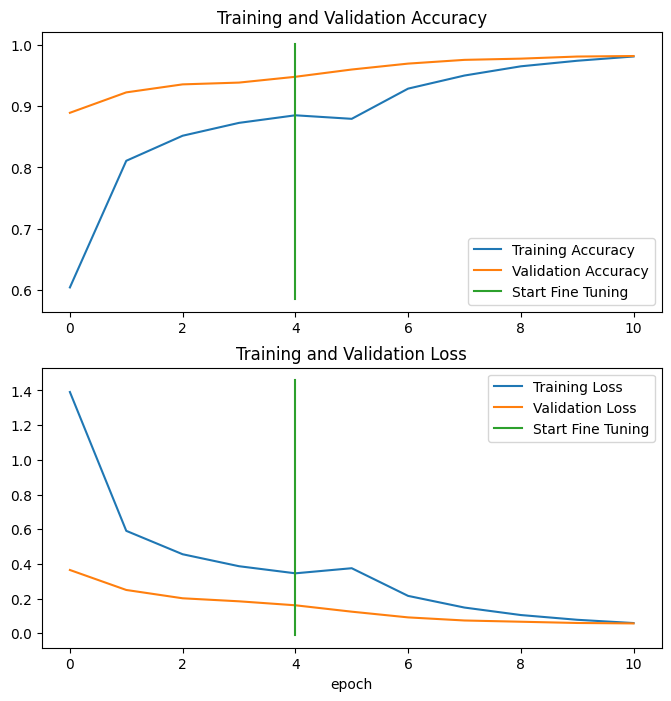

In [ ]:
compare_historys(history_50_percent_resnet, history_50_percent_resnet_fine)

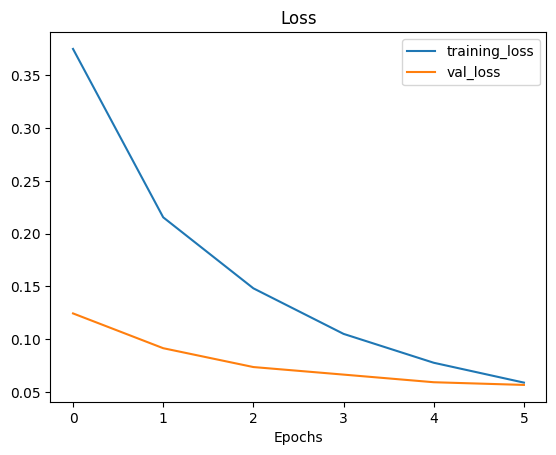

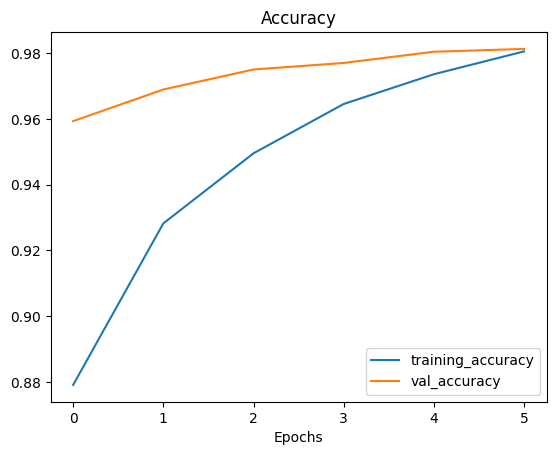

In [ ]:
plot_loss_curves(history_50_percent_resnet_fine)

In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import helper_functions

model=load_model('fine_tune_100_percent_resnet20.h5')
model.evaluate(val_ds)

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - accuracy: 0.9806 - loss: 0.0600


[0.0599231980741024, 0.9808786511421204]

NameError: name 'plot_loss_curves' is not defined

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np

# Image size used by ResNet
img_size = (128, 128)
batch_size = 16

train_ds = image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

valid_ds = image_dataset_from_directory(
    valid_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

class_names = train_ds.class_names
print("Total disease classes are:", len(class_names))

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.
Total disease classes are: 38


In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y)).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.map(lambda x, y: (preprocess_input(x), y)).cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

base_model = ResNet50(include_top=False, input_shape=(128, 128, 3), weights='imagenet')
base_model.trainable = False  # Freeze for transfer learning

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,122,022 (92.02 MB)

 Trainable params: 534,310 (2.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
epochs = 5
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=epochs
)

Epoch 1/5
3514/3514 ━━━━━━━━━━━━━━━━━━━━ 152s 39ms/step - accuracy: 0.6706 - loss: 1.1532 - val_accuracy: 0.9179 - val_loss: 0.2439
Epoch 2/5
3514/3514 ━━━━━━━━━━━━━━━━━━━━ 165s 30ms/step - accuracy: 0.8512 - loss: 0.4578 - val_accuracy: 0.9302 - val_loss: 0.2019
Epoch 3/5
3514/3514 ━━━━━━━━━━━━━━━━━━━━ 123s 25ms/step - accuracy: 0.8751 - loss: 0.3905 - val_accuracy: 0.9412 - val_loss: 0.1813
Epoch 4/5
3514/3514 ━━━━━━━━━━━━━━━━━━━━ 141s 25ms/step - accuracy: 0.8879 - loss: 0.3582 - val_accuracy: 0.9404 - val_loss: 0.1812
Epoch 5/5
3514/3514 ━━━━━━━━━━━━━━━━━━━━ 89s 25ms/step - accuracy: 0.8960 - loss: 0.3337 - val_accuracy: 0.9488 - val_loss: 0.1629


In [ ]:
tf.keras.models.save_model(model, 'updated_resnet80.h5')

In [ ]:
# Evaluate
loss, acc = model.evaluate(valid_ds)
print(f"Validation Accuracy: {acc*100:.2f}%")

# Predict
def predict_image(path):
    img = tf.keras.utils.load_img(path, target_size=(128, 128))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions)

    return predicted_class, confidence

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np

# Image size used by ResNet
img_size = (128, 128)
batch_size = 16

train_ds = image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

valid_ds = image_dataset_from_directory(
    valid_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

class_names = train_ds.class_names
print("Total disease classes are:", len(class_names))

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.
Total disease classes are: 38


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

base_model = ResNet50(include_top=False, input_shape=(128, 128, 3), weights='imagenet')
base_model.trainable = False  # Freeze for transfer learning

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,122,022 (92.02 MB)

 Trainable params: 534,310 (2.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
epochs = 10
history100 = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=epochs
)

Epoch 1/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 254s 55ms/step - accuracy: 0.6871 - loss: 1.0807 - val_accuracy: 0.9076 - val_loss: 0.2724
Epoch 2/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 129s 29ms/step - accuracy: 0.8583 - loss: 0.4352 - val_accuracy: 0.9356 - val_loss: 0.1911
Epoch 3/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 129s 29ms/step - accuracy: 0.8772 - loss: 0.3858 - val_accuracy: 0.9411 - val_loss: 0.1724
Epoch 4/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 109s 25ms/step - accuracy: 0.8907 - loss: 0.3460 - val_accuracy: 0.9402 - val_loss: 0.1788
Epoch 5/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 107s 24ms/step - accuracy: 0.8994 - loss: 0.3186 - val_accuracy: 0.9459 - val_loss: 0.1679
Epoch 6/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 163s 29ms/step - accuracy: 0.9035 - loss: 0.3056 - val_accuracy: 0.9510 - val_loss: 0.1517
Epoch 7/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 121s 24ms/step - accuracy: 0.9079 - loss: 0.2885 - val_accuracy: 0.9504 - val_loss: 0.1692
Epoch 8/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 164s 29ms/step - accuracy: 

In [ ]:
tf.keras.models.save_model(model, 'updated_resnet100.h5')

In [ ]:
import helper_functions
from helper_functions import compare_historys, plot_loss_curves

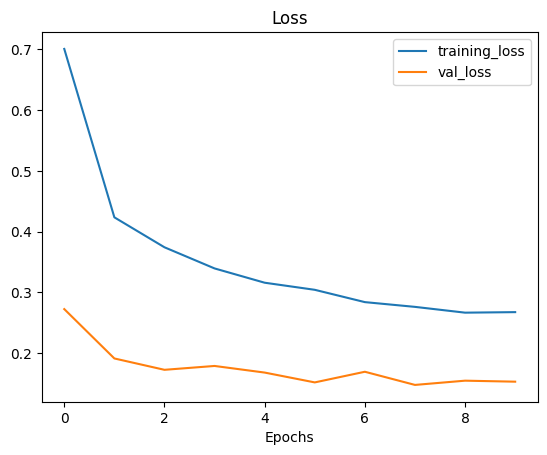

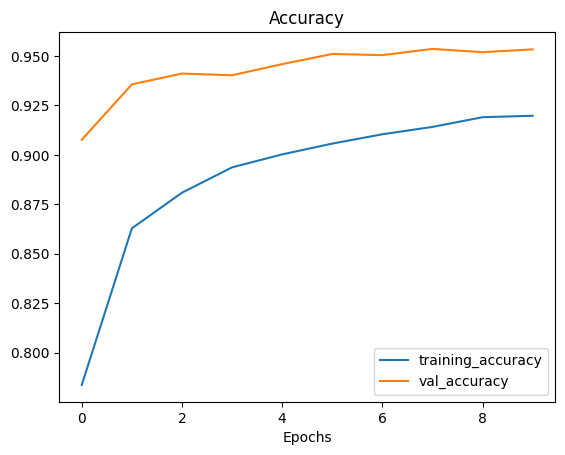

In [ ]:
plot_loss_curves(history100)

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels and predictions from val_ds
y_true = []
y_pred = []

for images, labels in valid_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def make_confusion_matrix2(y_true,
                           y_pred,
                           classes=None,
                           figsize=(14, 14),
                           text_size=10,
                           norm=False,
                           savefig=False,
                           filename="confusion_matrix.png"):
    """
    Plots a labeled confusion matrix.
    """

    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] if norm else None
    n_classes = cm.shape[0]

    # Adjust figure size automatically for large numbers of classes
    if n_classes > 30:
        figsize = (max(18, n_classes * 0.4), max(18, n_classes * 0.4))

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    # Label setup
    labels = classes if classes else np.arange(n_classes)

    # Truncate long labels for display
    short_labels = [label[:30] + "..." if len(label) > 30 else label for label in labels]

    ax.set(title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=short_labels,
        yticklabels=short_labels)


    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Rotate x-axis labels for better alignment
    plt.setp(ax.get_xticklabels(),
             rotation=90,
             ha="right",
             rotation_mode="anchor",
             fontsize=text_size)
    plt.setp(ax.get_yticklabels(), fontsize=text_size)

    # Add gridlines
    ax.set_xticks(np.arange(n_classes + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(n_classes + 1) - 0.5, minor=True)
    ax.grid(which="minor", color="gray", linestyle=":", linewidth=0.5)
    ax.tick_params(which="minor", bottom=False, left=False)

    # Set the text threshold
    threshold = (cm.max() + cm.min()) / 2.

    # Add text annotations
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            text = f"{cm[i, j]}\n({cm_norm[i, j]*100:.1f}%)"
        else:
            text = str(cm[i, j])
        ax.text(j, i,
                text,
                ha="center", va="center",
                color="white" if cm[i, j] > threshold else "black",
                fontsize=text_size)

    plt.tight_layout()

    # Save figure
    if savefig:
        fig.savefig(filename, dpi=300, bbox_inches="tight")

    plt.show()